<br>
<br>
**<font size=5><center>Predicting Default Rates for Lending Club</center></font>**

### Authors:
Devon Luongo <br>
Ankit Agarwal <br>
Bryn Clarke <br>
Ben Yuen

# IV. Baseline Models

*Libraries*

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA

In [2]:
df_X = pd.read_pickle("./data/df_X_imputed.pkl")
df_X = df_X.drop(["verification_status_None", "term_None", "application_type_None", "initial_list_status_None", "purpose_None", "emp_length_None", "home_ownership_None", "addr_state_None", "funded_amnt_inv", "num_actv_rev_tl", "tot_cur_bal"], axis=1)
df_y = pd.read_pickle("./data/df_y.pkl")

In [3]:
sclr = StandardScaler()
X = sclr.fit_transform(df_X)
y = df_y.values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20161201)

In [5]:
pca = PCA(n_components=100)
pca.fit(X)

for n in range(5, 105, 5):
    print "%d-components: %.2f%% variance explained" % (n, sum(pca.explained_variance_ratio_[1:n])*100)

5-components: 10.91% variance explained
10-components: 18.61% variance explained
15-components: 24.24% variance explained
20-components: 28.70% variance explained
25-components: 32.46% variance explained
30-components: 35.90% variance explained
35-components: 39.22% variance explained
40-components: 42.48% variance explained
45-components: 45.69% variance explained
50-components: 48.87% variance explained
55-components: 52.02% variance explained
60-components: 55.16% variance explained
65-components: 58.29% variance explained
70-components: 61.41% variance explained
75-components: 64.51% variance explained
80-components: 67.61% variance explained
85-components: 70.69% variance explained
90-components: 73.77% variance explained
95-components: 76.83% variance explained
100-components: 79.84% variance explained


In [6]:
n = 40
pca = PCA(n_components=n)
X_pc = pca.fit_transform(X)
print "%d-components: %.2f%% variance explained" % (n, sum(pca.explained_variance_ratio_)*100)
X_pc_train, X_pc_test, y_pc_train, y_pc_test = train_test_split(X_pc, y, test_size=0.3, random_state=20161201)

40-components: 48.01% variance explained


In [7]:
# Baseline models
# All positive (label every applicant as default)
class Pos_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.array([1] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

pos_model = Pos_model()
pos_model.fit(X_train, y_train)
pos_model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [8]:
# All negative (label every applicant as not default)
class Neg_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

neg_model = Neg_model()
neg_model.fit(X_train, y_train)
neg_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
# Random (randomly predict flu or not flu)
class Random_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

random_model = Random_model()
random_model.fit(X_train, y_train)
random_model.predict(X_test)

array([0, 1, 0, ..., 1, 0, 0])

In [10]:
def custom_cost(y, y_pred):
    cost_fixed_application = 10.0
    cost_fixed_servicing = 100.0
    cost_default = 15000.0
    cost_interest = -1000.0
    
    # TRUE POSITIVE: Predict default, applicant would default
    n_true_positive = sum((y==1) & (y_pred==1))
    # We only pay fixed application processing costs as we decline the loan
    cost_true_positive = n_true_positive*(cost_fixed_application)
    
    # TRUE NEGATIVE: Predict pay on time, applicant will pay on time
    n_true_negative = sum((y==0) & (y_pred==0))
    # We pay fixed application processing costs, costs of servicing the loan, and gain profit on interest payments
    cost_true_negative = n_true_negative*(cost_fixed_application + cost_fixed_servicing + cost_interest)
    
    # FALSE POSITIVE: Predict default, applicant would pay on time
    n_false_positive = sum((y==0) & (y_pred==1))
    # We only pay fixed application processing costs as we decline the loan
    cost_false_positive = n_false_positive*(cost_fixed_application)
    
    # FALSE NEGATIVE: Predict pay on time, applicant will default
    n_false_negative = sum((y==1) & (y_pred==0))
    # We pay fixed application processing costs, costs of servicing the loan, and the principal as the loan defaults
    cost_false_negative = n_false_negative*(cost_fixed_application + cost_fixed_servicing + cost_default)
    
    return (cost_true_positive + cost_true_negative + cost_false_positive + cost_false_negative)/len(y)

In [11]:
def test_model(model, label, scoring_funcs, use_pc=True):
    if use_pc:
        model.fit(X_pc_train, y_train)
        y_pred = model.predict(X_pc_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)        
        
    scores = {"model": label}
    for scoring_func in scoring_funcs:
        scores[scoring_func.__name__] = scoring_func(y_test, y_pred)
    
    return pd.DataFrame([scores]).set_index("model")

def compare_models(models, labels, scoring_funcs, use_pc=True):
    return pd.concat([test_model(model, label, scoring_funcs, use_pc) for model, label in zip(models, labels)])

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

compare_models([pos_model, neg_model, random_model], ["Positive Model", "Negative Model", "Random Model"], [custom_cost, accuracy_score, average_precision_score, f1_score, log_loss, precision_score, recall_score, roc_auc_score])

/home/ubuntu/anaconda3/envs/cs109a_proj/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/cs109a_proj/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,accuracy_score,average_precision_score,custom_cost,f1_score,log_loss,precision_score,recall_score,roc_auc_score
model,,,,,,,,
Positive Model,0.196514,0.598257,10.000000,0.328477,27.752072,0.196514,1.000000,0.500000
Negative Model,0.803486,0.598257,2254.220934,0.000000,6.787346,0.000000,0.000000,0.500000
Random Model,0.499974,0.399108,1122.874190,0.283470,17.270593,0.197293,0.503318,0.501237


# V. Prediction Models

In [20]:
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

xg = xgb.XGBClassifier(nthread=8)
%time xg.fit(X_train, y_train)

KeyboardInterrupt: 

In [129]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda__None__0 = QuadraticDiscriminantAnalysis(priors=None, reg_param=0)
qda__None__1En20 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-20))
qda__None__1En19 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-19))
qda__None__1En18 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-18))
qda__None__1En17 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-17))
qda__None__1En16 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-16))
qda__None__1En15 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-15))
qda__None__1En14 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-14))
qda__None__1En13 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-13))
qda__None__1En12 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-12))
qda__None__1En11 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-11))
qda__None__1En10 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-10))
qda__None__1En9 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-9))
qda__None__1En8 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-8))
qda__None__1En7 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-7))
qda__None__1En6 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-6))
qda__None__1En5 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-5))
qda__None__1En4 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-4))
qda__None__1En3 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-3))
qda__None__1En2 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-2))
qda__None__1En1 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-1))
qda__None__1E0 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(0))

qda_search_reg = compare_models([qda__None__0,
                                 qda__None__1En20,
                                 qda__None__1En19,
                                 qda__None__1En18,
                                 qda__None__1En17,
                                 qda__None__1En16,
                                 qda__None__1En15,
                                 qda__None__1En14,
                                 qda__None__1En13,
                                 qda__None__1En12,
                                 qda__None__1En11,
                                 qda__None__1En10,
                                 qda__None__1En9,
                                 qda__None__1En8,
                                 qda__None__1En7,
                                 qda__None__1En6,
                                 qda__None__1En5,
                                 qda__None__1En4,
                                 qda__None__1En3,
                                 qda__None__1En2,
                                 qda__None__1En1,
                                 qda__None__1E0],
                                ["qda__None__0",
                                 "qda__None__1En20",
                                 "qda__None__1En19",
                                 "qda__None__1En18",
                                 "qda__None__1En17",
                                 "qda__None__1En16",
                                 "qda__None__1En15",
                                 "qda__None__1En14",
                                 "qda__None__1En13",
                                 "qda__None__1En12",
                                 "qda__None__1En11",
                                 "qda__None__1En10",
                                 "qda__None__1En9",
                                 "qda__None__1En8",
                                 "qda__None__1En7",
                                 "qda__None__1En6",
                                 "qda__None__1En5",
                                 "qda__None__1En4",
                                 "qda__None__1En3",
                                 "qda__None__1En2",
                                 "qda__None__1En1",
                                 "qda__None__1E0"],
                                [custom_cost,
                                 accuracy_score,
                                 average_precision_score,
                                 f1_score,
                                 log_loss,
                                 precision_score,
                                 recall_score,
                                 roc_auc_score])

qda_search_reg

,accuracy_score,average_precision_score,custom_cost,f1_score,log_loss,precision_score,recall_score,roc_auc_score
model,,,,,,,,
qda__None__0,0.644016,0.333282,1522.407944,0.257238,12.295416,0.218009,0.313685,0.519246
qda__None__1En20,0.267687,0.587762,54.393113,0.340298,25.293786,0.206750,0.961136,0.529611
qda__None__1En19,0.271761,0.587257,56.535970,0.341064,25.153060,0.207412,0.959054,0.531360
qda__None__1En18,0.276091,0.586522,60.022162,0.341784,25.003502,0.208070,0.956409,0.533055
qda__None__1En17,0.280498,0.585902,62.834129,0.342586,24.851294,0.208781,0.953980,0.534880
qda__None__1En16,0.285194,0.585199,66.111490,0.343425,24.689077,0.209535,0.951290,0.536787
qda__None__1En15,0.290155,0.584895,66.972383,0.344544,24.517733,0.210462,0.949382,0.539153
qda__None__1En14,0.295414,0.584331,69.380327,0.345614,24.336085,0.211388,0.946823,0.541459
qda__None__1En13,0.301705,0.583675,72.191442,0.346917,24.118813,0.212517,0.943787,0.544227


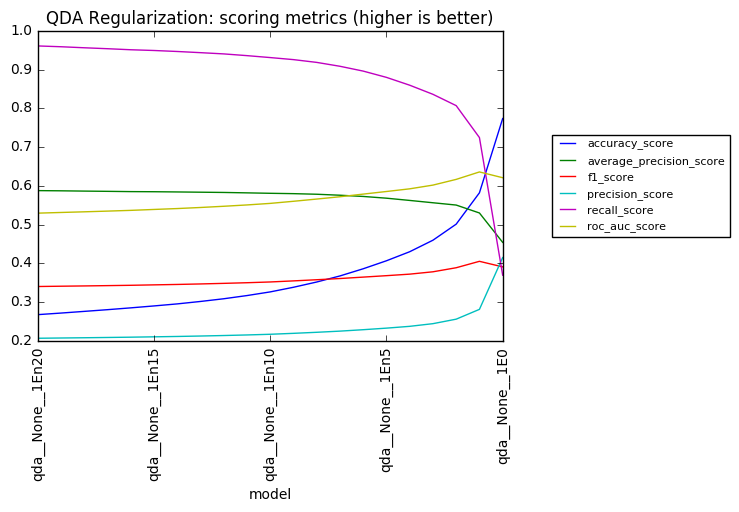

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt
qda_search_reg.ix[1:].drop(["custom_cost", "log_loss"], axis=1).plot()
plt.legend(loc='right', prop={'size':8}, bbox_to_anchor=(1.5,0.5))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("QDA Regularization: scoring metrics (higher is better)")

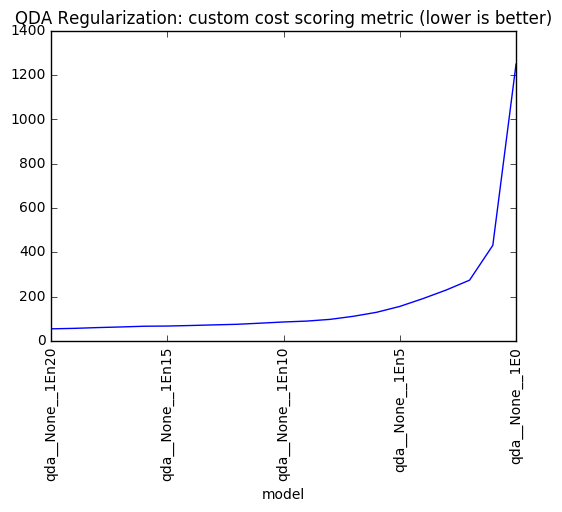

In [136]:
plt.figure()
qda_search_reg.ix[1:].custom_cost.plot()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("QDA Regularization: custom cost scoring metric (lower is better)")